This notebook is part of the $\omega radlib$ documentation: https://docs.wradlib.org.

Copyright (c) $\omega radlib$ developers.
Distributed under the MIT License. See LICENSE.txt for more info.

# Recipe #2: Reading and visualizing an ODIM_H5 polar volume

This recipe shows how extract the polar volume data from an ODIM_H5 hdf5 file (KNMI example file from OPERA), contruct a 3-dimensional Cartesian volume and produce a diagnostic plot. The challenge for this file is that for each elevation angle, the scan strategy is different.

In [1]:
import wradlib as wrl
import matplotlib.pyplot as pl
import warnings
warnings.filterwarnings('ignore')
try:
    get_ipython().magic("matplotlib inline")
except:
    pl.ion()
import numpy as np

3-D interpolation took: 0:00:02.098025


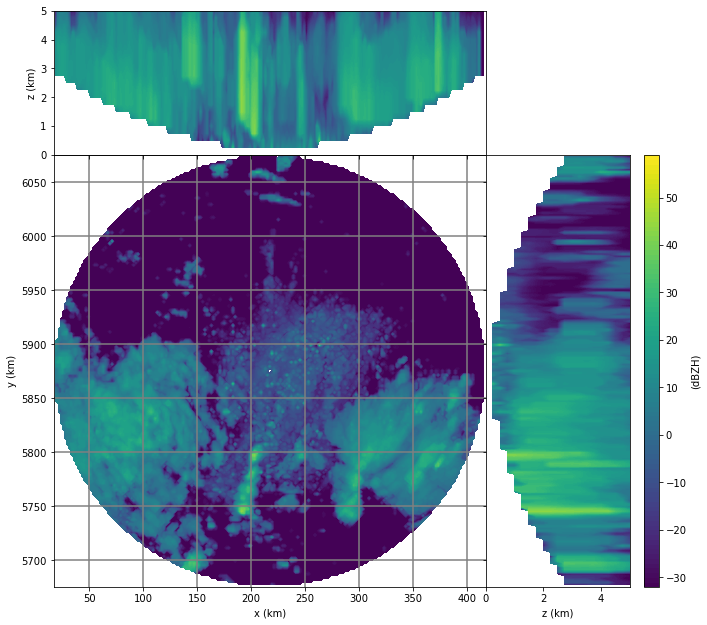

In [2]:
import datetime as dt
from osgeo import osr

# read the data (sample file in WRADLIB_DATA)
filename = wrl.util.get_wradlib_data_file('hdf5/knmi_polar_volume.h5')
raw = wrl.io.read_opera_hdf5(filename)
# this is the radar position tuple (longitude, latitude, altitude)
sitecoords = (raw["where"]["lon"][0], raw["where"]["lat"][0],
              raw["where"]["height"][0])
# define your cartesian reference system
# proj = wradlib.georef.create_osr(32632)
proj = osr.SpatialReference()
proj.ImportFromEPSG(32632)
# containers to hold Cartesian bin coordinates and data
xyz, data = np.array([]).reshape((-1, 3)), np.array([])
# iterate over 14 elevation angles
for i in range(14):
    # get the scan metadata for each elevation
    where = raw["dataset%d/where" % (i + 1)]
    what = raw["dataset%d/data1/what" % (i + 1)]
    # define arrays of polar coordinate arrays (azimuth and range)
    az = np.arange(0., 360., 360. / where["nrays"])
    # rstart is given in km, so multiply by 1000.
    rstart = where["rstart"] * 1000.
    r = np.arange(rstart,
                  rstart + where["nbins"] * where["rscale"],
                  where["rscale"])
    # derive 3-D Cartesian coordinate tuples
    xyz_ = wrl.vpr.volcoords_from_polar(sitecoords, where["elangle"],
                                        az, r, proj)
    # get the scan data for this elevation
    #   here, you can do all the processing on the 2-D polar level
    #   e.g. clutter elimination, attenuation correction, ...
    data_ = what["offset"] + what["gain"] * raw[
        "dataset%d/data1/data" % (i + 1)]
    # transfer to containers
    xyz, data = np.vstack((xyz, xyz_)), np.append(data, data_.ravel())

# generate 3-D Cartesian target grid coordinates
maxrange = 200000.
minelev = 0.1
maxelev = 25.
maxalt = 5000.
horiz_res = 2000.
vert_res = 250.
trgxyz, trgshape = wrl.vpr.make_3d_grid(sitecoords, proj, maxrange,
                                        maxalt, horiz_res, vert_res)

# interpolate to Cartesian 3-D volume grid
tstart = dt.datetime.now()
gridder = wrl.vpr.CAPPI(xyz, trgxyz, trgshape, maxrange, minelev,
                        maxelev)
vol = np.ma.masked_invalid(gridder(data).reshape(trgshape))
print("3-D interpolation took:", dt.datetime.now() - tstart)

# diagnostic plot
trgx = trgxyz[:, 0].reshape(trgshape)[0, 0, :]
trgy = trgxyz[:, 1].reshape(trgshape)[0, :, 0]
trgz = trgxyz[:, 2].reshape(trgshape)[:, 0, 0]
wrl.vis.plot_max_plan_and_vert(trgx, trgy, trgz, vol, unit="dBZH",
                               levels=range(-32, 60))

<div class="alert alert-info">

**Note** <br>

In order to run the recipe code, you need to extract the sample data into a directory pointed to by environment variable ``WRADLIB_DATA``.
</div>